In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


In [2]:
import os

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import svm, tree, metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold

import recipes.evaluation_classification as evalc
# import recipes.evaluation_classification as evalc
import recipes.exploratory_analysis as eda

print("All libraries loaded!!")

% matplotlib inline


# os.chdir(os.path.join(os.getcwd(), '..\\\\..'))



All libraries loaded!!


In [3]:


def preprocess_data(df):
    # data cleaning and completion
    # replace white spaces
    df.columns = [x.strip().replace("+", "").replace(" ", "_")
                  for x in df.columns]

    # filter columns related to weather events
    weather_columns = df.columns.tolist()
    weather_columns = [x for x in weather_columns if "DEC_EVENT" in x]
    selected_cols = ["IDEST", "ZV", "DATE", "PORC__DET"] + weather_columns
    df = df[selected_cols]
    df.columns = [x.lower() for x in df.columns]
    selected_cols = [x.lower() for x in selected_cols]

    # df.drop(["Temperatura"], axis=1, inplace=True)
    # df.drop([y_var], axis=1, inplace = True)
    # ordenar columnas por nombre
    df = df.reindex_axis(sorted(df.columns), axis=1)
    return df



In [4]:
input_file = "resources/processed/full_data.h5"
output_folder = "report/"


# Lectura de datos
Tenemos los datos de las estaciones climatológicas de 2015 en adelante asociados a los datos de
campo en el fichero hd5 full_data.h5.


In [5]:
# read and clean data
df = pd.read_hdf(input_file)


In [6]:
df = preprocess_data(df)
print("data loaded!")


data loaded!


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


# Analizar correlación de datos
En este caso utilizamos como variable respuesta y = "% de muestras de campo con incidencia detectada", se corresponde con la variable df["porc__det"].
Al ser una variable contínua podemos calcular Pearson/Spearman para ver la corrección lineal entre las variables de década y la variable respuesta.



>>>> Data correlations method spearman


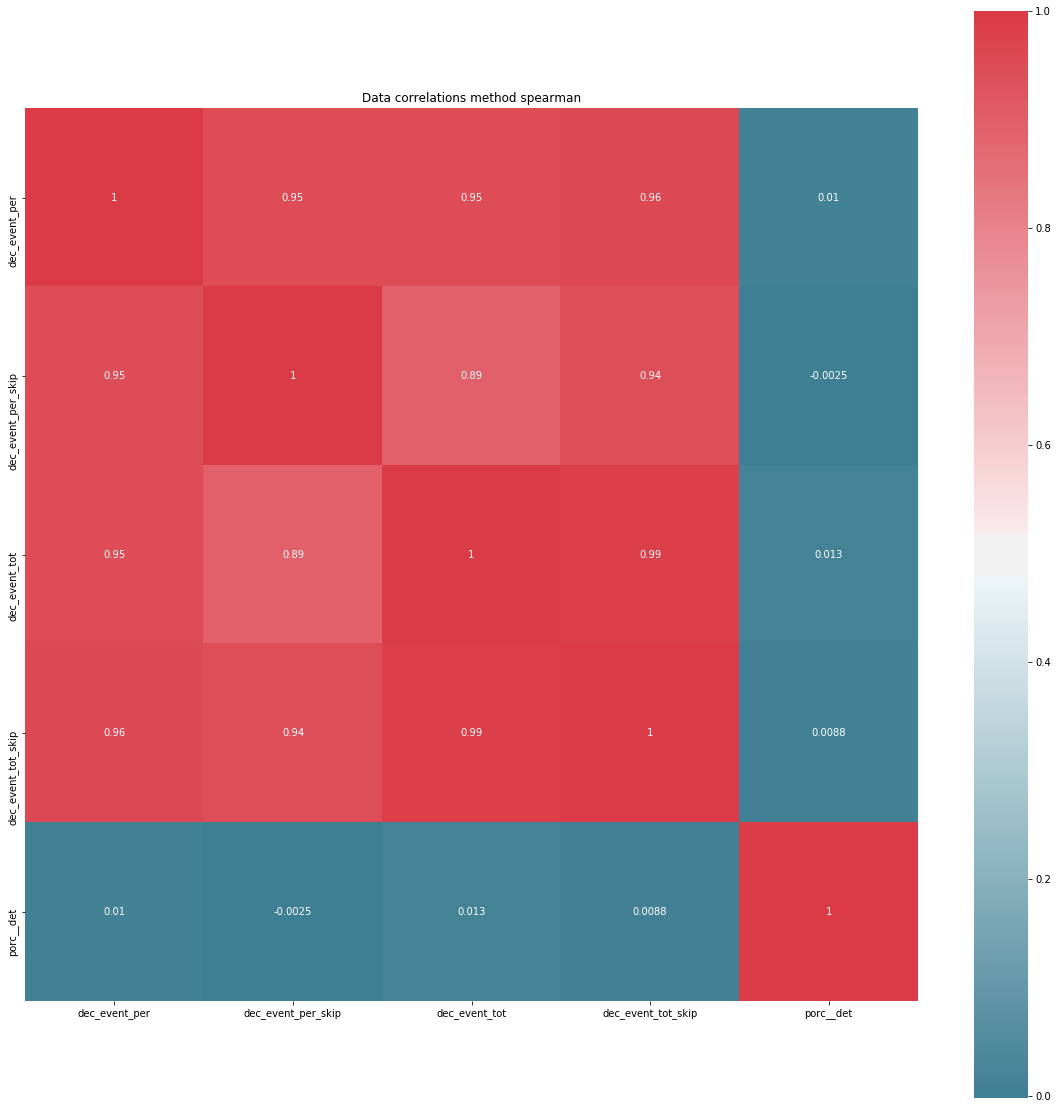

In [7]:
corr_matrix = eda.analyze_correlation(df, corr_method="spearman", excluded_columns=["IDEST", "ZV", "DATE"],
                                      output_file=os.path.join(output_folder, "corr_spearman.png"))


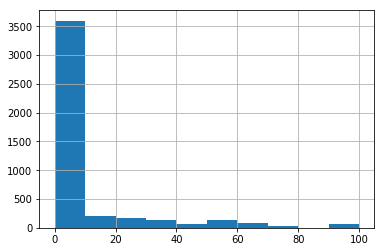

In [8]:
# response variable classes balance
df["porc__det"].hist()


In [9]:

y_var = "porc__det"
y = df[y_var] / 100  # 0-100 -> 0-1
exclude_cols = [y_var, "date", "zv", "idest"]
exclude_cols.extend([x for x in df.columns if (
    "temp_" in x) or ("hum_" in x) or ("prec_" in x)])
X = df.drop(exclude_cols, axis=1)
# normalizar y estandarizar
X = eda.normalize_data_sklearn(X)
X = eda.standardize_data_sklearn(X)


Al ser la variable respuesta contínua, en este caso entrenamos regresores en lugar de clasificadores.
Utilizamos como métricas de entrenamiento el R2 entre el valor observado y el valor predecido y el error cuadrático medio (MSE).

C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


['r2']: Ridge -0.0180 (0.0074)
['r2']: simpleR -0.0185 (0.0073)
['r2']: SVR -0.0214 (0.0169)
['r2']: DTR -0.6744 (0.2510)
['neg_mean_squared_error']: Ridge -0.0374 (0.0057)
['neg_mean_squared_error']: simpleR -0.0374 (0.0057)
['neg_mean_squared_error']: SVR -0.0375 (0.0059)
['neg_mean_squared_error']: DTR -0.0617 (0.0048)


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


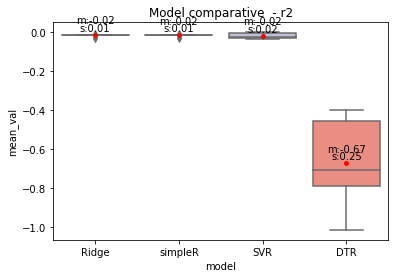

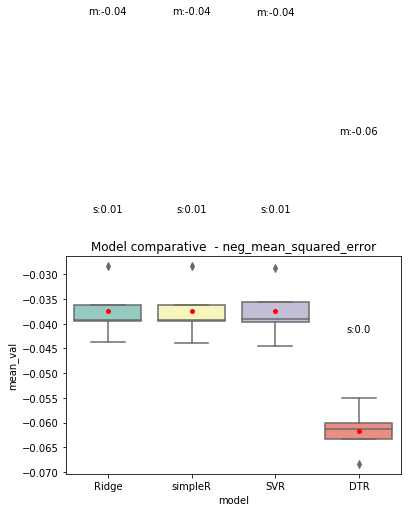

In [10]:
# kfold = StratifiedKFold(n_splits=10)
kfold = KFold(n_splits=10)

models = [["simpleR", LinearRegression()],
          ["Ridge", Ridge()],
          ["SVR", svm.SVR()],
          ["DTR", tree.DecisionTreeRegressor()],
          ]
# métrica F1-score para balancear error tipo I - Tipo 2
scorers = ["r2", "neg_mean_squared_error"]
for scoring in scorers:
    summary = evalc.cross_val_summary_simple(
        models, X, y, scoring=scoring, options={"title": scoring})


Los resultados no son demasiado buenos. Los modelos optimizados sobre la métrica R2 tienen valores muy bajos, excepto para el caso del Regresor de árbol.
En el caso del error cuadrático medio, los valores de error se mueven en torno a 0.037, en la práctica esto supondrían  equivocarse por un porcentaje del 20%.
Al menos la variabilidad es relativamente baja (0.006), pero habría que analizar en mayor profundidad.

Entrenamos un modelo con el conjunto completo de datos y vamos a ver cómo influyen las variables Xi en la variable respuesta.

In [11]:
model = LinearRegression()

X_train, X_test, Y_train, y_true = train_test_split(X, y, test_size=0.3)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("MSE del modelo: {}".format(metrics.mean_squared_error(y_true, y_pred)))


MSE del modelo: 0.03843470263472242


Un error en torno al 20% en la predicción del % de parcelas afectadas.
Representamos el valor predecido del %detecciones vs el valor real para valorar cómo se distribuye el error de las predicciones.

C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


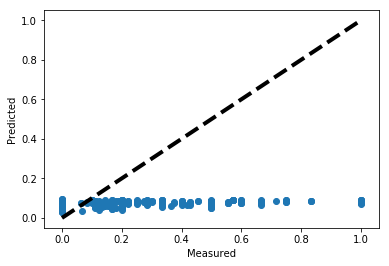

In [12]:
plt
fig, ax = plt.subplots()
ax.scatter(y_true, y_pred)
ax.plot([y_true.min(), y_true.max()], [
        y_true.min(), y_true.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()


Al tener muchas más observaciones cercanas a 0, el regresor acierta más en la zona baja de la gráfica que en la alta, hay que valorar aplicar undersampling.

Imprimirmos los valores de los coeficientes del regresor para ver la importancia relativa que tienen las variables Xi 

In [13]:
for idx, c in enumerate(model.coef_):
    print("{} = {}".format(X.columns[idx], c))


dec_event_per = -0.014510416033931328
dec_event_per_skip = -0.0009868562120727477
dec_event_tot = 0.027506737273580054
dec_event_tot_skip = -0.0205227143090738


Las variables de número de periodos parecen tener bastante menor influencia en la variable respuesta que las de conteo total de periodos, y además existe una alta correlación entre estas variables.
Las quitamos y reentrenamos para ver cómo afecta. 

MSE del modelo: 0.03406971507097332


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


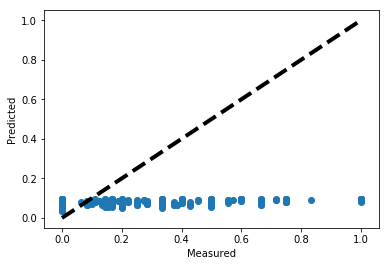

In [14]:
model = LinearRegression()
X.drop(["dec_event_per", "dec_event_per_skip"], axis=1, inplace=True)
X_train, X_test, Y_train, y_true = train_test_split(X, y, test_size=0.3)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
print("MSE del modelo: {}".format(metrics.mean_squared_error(y_true, y_pred)))

fig, ax = plt.subplots()
ax.scatter(y_true, y_pred)
ax.plot([y_true.min(), y_true.max()], [
        y_true.min(), y_true.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()


El modelo empeora, aunque mínimamente.
